In [68]:
import lightgbm
import pandas as pd

In [69]:
init_record = pd.read_csv("../../Data/LWB_Monthly_data.csv")


In [70]:
init_record['_key_occurreddate_month']=init_record['_key_occurreddate_month'].astype("datetime64[ns]")
init_record = init_record.set_index(['_key_client_id', '_key_occurreddate_month'])

In [71]:
init_record.shape

(123311, 339)

## Split Dataset to three part: Training, evaluation and testing data

In [72]:
import random
clientList = list(set(init_record.index.get_level_values(0)))

In [73]:
random.shuffle(clientList)

In [74]:
length = len(clientList)
ratio = int(length*0.1)
trainIDs = clientList[ratio:]
testIDs = clientList[:ratio]
train0 = init_record.drop(testIDs, level=0)
test = init_record.drop(trainIDs, level=0)

In [75]:
print(train0.shape)
print(test.shape)

(111071, 339)
(12240, 339)


In [76]:
ratio = int(len(trainIDs)*0.25)
trainRatio = trainIDs[ratio:]
evalRatio  = trainIDs[:ratio]
train = train0.drop(evalRatio, level=0)
evl = train0.drop(trainRatio,level=0)

In [77]:
print(train.shape)
print(evl.shape)
print(test.shape)

(83366, 339)
(27705, 339)
(12240, 339)


In [78]:
import numpy as np

In [79]:

def construct_feature_label(data):
    y = []
    clientList = list(set(data.index.get_level_values(0)))
    data['response_variable'] = data.groupby(level=0)['response_variable'].shift(-1)  
    data = data.groupby(level=0, as_index=False).apply(lambda group: group.iloc[:-1])
    #print(data.loc["0000D172-EA88-432F-8235-9FAA00D29072"]['response_variable'])
    y = data['response_variable']
    x = data.drop('response_variable',axis='columns')
    return x, y

x_train, y_train = construct_feature_label(train)
x_eval, y_eval = construct_feature_label(evl)

In [80]:
print(len(y_train))
print(x_train.shape)
print(len(y_eval))
print(x_eval.shape)

74317
(74317, 338)
24689
(24689, 338)


# Start training and predictions

In [81]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt

In [82]:
train_data = lightgbm.Dataset(x_train, label=y_train)
eval_data = lightgbm.Dataset(x_eval, label=y_eval)

In [83]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}


In [84]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=eval_data,
                       num_boost_round=5000)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.516140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's auc: 0.91781
[2]	valid_0's auc: 0.926736
[3]	valid_0's auc: 0.927974
[4]	valid_0's auc: 0.928272
[5]	valid_0's auc: 0.929186
[6]	valid_0's auc: 0.929725
[7]	valid_0's auc: 0.930008
[8]	valid_0's auc: 0.930267
[9]	valid_0's auc: 0.930393
[10]	valid_0's auc

[260]	valid_0's auc: 0.936923
[261]	valid_0's auc: 0.936896
[262]	valid_0's auc: 0.93687
[263]	valid_0's auc: 0.93685
[264]	valid_0's auc: 0.936826
[265]	valid_0's auc: 0.936798
[266]	valid_0's auc: 0.936835
[267]	valid_0's auc: 0.936809
[268]	valid_0's auc: 0.936773
[269]	valid_0's auc: 0.936766
[270]	valid_0's auc: 0.936724
[271]	valid_0's auc: 0.936697
[272]	valid_0's auc: 0.936706
[273]	valid_0's auc: 0.936684
[274]	valid_0's auc: 0.936653
[275]	valid_0's auc: 0.936664
[276]	valid_0's auc: 0.936646
[277]	valid_0's auc: 0.936599
[278]	valid_0's auc: 0.936544
[279]	valid_0's auc: 0.936525
[280]	valid_0's auc: 0.936487
[281]	valid_0's auc: 0.936468
[282]	valid_0's auc: 0.936462
[283]	valid_0's auc: 0.936469
[284]	valid_0's auc: 0.936469
[285]	valid_0's auc: 0.936518
[286]	valid_0's auc: 0.936516
[287]	valid_0's auc: 0.936536
[288]	valid_0's auc: 0.9365
[289]	valid_0's auc: 0.936495
[290]	valid_0's auc: 0.936513
[291]	valid_0's auc: 0.93653
[292]	valid_0's auc: 0.936497
[293]	valid_0's

[541]	valid_0's auc: 0.934486
[542]	valid_0's auc: 0.934473
[543]	valid_0's auc: 0.934494
[544]	valid_0's auc: 0.934507
[545]	valid_0's auc: 0.934503
[546]	valid_0's auc: 0.93453
[547]	valid_0's auc: 0.934518
[548]	valid_0's auc: 0.934518
[549]	valid_0's auc: 0.934524
[550]	valid_0's auc: 0.934517
[551]	valid_0's auc: 0.934515
[552]	valid_0's auc: 0.934505
[553]	valid_0's auc: 0.934514
[554]	valid_0's auc: 0.934533
[555]	valid_0's auc: 0.9345
[556]	valid_0's auc: 0.934492
[557]	valid_0's auc: 0.934499
[558]	valid_0's auc: 0.93452
[559]	valid_0's auc: 0.934522
[560]	valid_0's auc: 0.93452
[561]	valid_0's auc: 0.93451
[562]	valid_0's auc: 0.934493
[563]	valid_0's auc: 0.934488
[564]	valid_0's auc: 0.934512
[565]	valid_0's auc: 0.934566
[566]	valid_0's auc: 0.934571
[567]	valid_0's auc: 0.934587
[568]	valid_0's auc: 0.934595
[569]	valid_0's auc: 0.934583
[570]	valid_0's auc: 0.934587
[571]	valid_0's auc: 0.934589
[572]	valid_0's auc: 0.934608
[573]	valid_0's auc: 0.934612
[574]	valid_0's 

[822]	valid_0's auc: 0.93342
[823]	valid_0's auc: 0.933405
[824]	valid_0's auc: 0.933417
[825]	valid_0's auc: 0.933398
[826]	valid_0's auc: 0.933426
[827]	valid_0's auc: 0.933448
[828]	valid_0's auc: 0.933478
[829]	valid_0's auc: 0.933455
[830]	valid_0's auc: 0.933427
[831]	valid_0's auc: 0.93338
[832]	valid_0's auc: 0.933362
[833]	valid_0's auc: 0.933358
[834]	valid_0's auc: 0.933342
[835]	valid_0's auc: 0.933297
[836]	valid_0's auc: 0.933309
[837]	valid_0's auc: 0.933289
[838]	valid_0's auc: 0.933259
[839]	valid_0's auc: 0.933257
[840]	valid_0's auc: 0.933269
[841]	valid_0's auc: 0.933274
[842]	valid_0's auc: 0.933262
[843]	valid_0's auc: 0.933267
[844]	valid_0's auc: 0.933281
[845]	valid_0's auc: 0.933294
[846]	valid_0's auc: 0.933295
[847]	valid_0's auc: 0.933294
[848]	valid_0's auc: 0.933251
[849]	valid_0's auc: 0.933213
[850]	valid_0's auc: 0.933209
[851]	valid_0's auc: 0.933181
[852]	valid_0's auc: 0.93319
[853]	valid_0's auc: 0.93317
[854]	valid_0's auc: 0.933167
[855]	valid_0'

[1101]	valid_0's auc: 0.932229
[1102]	valid_0's auc: 0.932256
[1103]	valid_0's auc: 0.932253
[1104]	valid_0's auc: 0.932283
[1105]	valid_0's auc: 0.932277
[1106]	valid_0's auc: 0.932248
[1107]	valid_0's auc: 0.932218
[1108]	valid_0's auc: 0.932233
[1109]	valid_0's auc: 0.932233
[1110]	valid_0's auc: 0.932213
[1111]	valid_0's auc: 0.932184
[1112]	valid_0's auc: 0.932144
[1113]	valid_0's auc: 0.932147
[1114]	valid_0's auc: 0.932123
[1115]	valid_0's auc: 0.93212
[1116]	valid_0's auc: 0.932124
[1117]	valid_0's auc: 0.932149
[1118]	valid_0's auc: 0.932174
[1119]	valid_0's auc: 0.932157
[1120]	valid_0's auc: 0.932138
[1121]	valid_0's auc: 0.932151
[1122]	valid_0's auc: 0.932144
[1123]	valid_0's auc: 0.932136
[1124]	valid_0's auc: 0.932134
[1125]	valid_0's auc: 0.932155
[1126]	valid_0's auc: 0.93211
[1127]	valid_0's auc: 0.932072
[1128]	valid_0's auc: 0.932037
[1129]	valid_0's auc: 0.932048
[1130]	valid_0's auc: 0.932022
[1131]	valid_0's auc: 0.93197
[1132]	valid_0's auc: 0.931961
[1133]	vali

[1375]	valid_0's auc: 0.93113
[1376]	valid_0's auc: 0.931157
[1377]	valid_0's auc: 0.931162
[1378]	valid_0's auc: 0.931134
[1379]	valid_0's auc: 0.931133
[1380]	valid_0's auc: 0.931127
[1381]	valid_0's auc: 0.931102
[1382]	valid_0's auc: 0.931088
[1383]	valid_0's auc: 0.931069
[1384]	valid_0's auc: 0.931087
[1385]	valid_0's auc: 0.931093
[1386]	valid_0's auc: 0.931063
[1387]	valid_0's auc: 0.931021
[1388]	valid_0's auc: 0.931
[1389]	valid_0's auc: 0.930966
[1390]	valid_0's auc: 0.930961
[1391]	valid_0's auc: 0.93096
[1392]	valid_0's auc: 0.93094
[1393]	valid_0's auc: 0.930951
[1394]	valid_0's auc: 0.930941
[1395]	valid_0's auc: 0.930937
[1396]	valid_0's auc: 0.93095
[1397]	valid_0's auc: 0.930939
[1398]	valid_0's auc: 0.930946
[1399]	valid_0's auc: 0.930887
[1400]	valid_0's auc: 0.930879
[1401]	valid_0's auc: 0.930874
[1402]	valid_0's auc: 0.930873
[1403]	valid_0's auc: 0.930881
[1404]	valid_0's auc: 0.930898
[1405]	valid_0's auc: 0.930887
[1406]	valid_0's auc: 0.930886
[1407]	valid_0'

[1641]	valid_0's auc: 0.92966
[1642]	valid_0's auc: 0.929679
[1643]	valid_0's auc: 0.929661
[1644]	valid_0's auc: 0.929656
[1645]	valid_0's auc: 0.929619
[1646]	valid_0's auc: 0.929615
[1647]	valid_0's auc: 0.929602
[1648]	valid_0's auc: 0.929569
[1649]	valid_0's auc: 0.929552
[1650]	valid_0's auc: 0.929549
[1651]	valid_0's auc: 0.92953
[1652]	valid_0's auc: 0.929513
[1653]	valid_0's auc: 0.929532
[1654]	valid_0's auc: 0.929519
[1655]	valid_0's auc: 0.929496
[1656]	valid_0's auc: 0.929483
[1657]	valid_0's auc: 0.929486
[1658]	valid_0's auc: 0.929448
[1659]	valid_0's auc: 0.929412
[1660]	valid_0's auc: 0.929451
[1661]	valid_0's auc: 0.929433
[1662]	valid_0's auc: 0.929413
[1663]	valid_0's auc: 0.92941
[1664]	valid_0's auc: 0.929419
[1665]	valid_0's auc: 0.929413
[1666]	valid_0's auc: 0.929461
[1667]	valid_0's auc: 0.929451
[1668]	valid_0's auc: 0.929452
[1669]	valid_0's auc: 0.929482
[1670]	valid_0's auc: 0.92947
[1671]	valid_0's auc: 0.929479
[1672]	valid_0's auc: 0.929481
[1673]	valid

[1907]	valid_0's auc: 0.928946
[1908]	valid_0's auc: 0.928951
[1909]	valid_0's auc: 0.928924
[1910]	valid_0's auc: 0.928905
[1911]	valid_0's auc: 0.928896
[1912]	valid_0's auc: 0.928887
[1913]	valid_0's auc: 0.928879
[1914]	valid_0's auc: 0.92888
[1915]	valid_0's auc: 0.928867
[1916]	valid_0's auc: 0.928856
[1917]	valid_0's auc: 0.928867
[1918]	valid_0's auc: 0.92887
[1919]	valid_0's auc: 0.928844
[1920]	valid_0's auc: 0.928834
[1921]	valid_0's auc: 0.928825
[1922]	valid_0's auc: 0.928814
[1923]	valid_0's auc: 0.928828
[1924]	valid_0's auc: 0.928836
[1925]	valid_0's auc: 0.928841
[1926]	valid_0's auc: 0.928843
[1927]	valid_0's auc: 0.928827
[1928]	valid_0's auc: 0.928817
[1929]	valid_0's auc: 0.928825
[1930]	valid_0's auc: 0.928774
[1931]	valid_0's auc: 0.928766
[1932]	valid_0's auc: 0.928776
[1933]	valid_0's auc: 0.928768
[1934]	valid_0's auc: 0.928769
[1935]	valid_0's auc: 0.928748
[1936]	valid_0's auc: 0.92873
[1937]	valid_0's auc: 0.92876
[1938]	valid_0's auc: 0.928733
[1939]	valid

[2173]	valid_0's auc: 0.928288
[2174]	valid_0's auc: 0.928301
[2175]	valid_0's auc: 0.928284
[2176]	valid_0's auc: 0.928278
[2177]	valid_0's auc: 0.928288
[2178]	valid_0's auc: 0.928289
[2179]	valid_0's auc: 0.928291
[2180]	valid_0's auc: 0.928275
[2181]	valid_0's auc: 0.928289
[2182]	valid_0's auc: 0.92829
[2183]	valid_0's auc: 0.928311
[2184]	valid_0's auc: 0.928314
[2185]	valid_0's auc: 0.928322
[2186]	valid_0's auc: 0.928333
[2187]	valid_0's auc: 0.928308
[2188]	valid_0's auc: 0.928309
[2189]	valid_0's auc: 0.928323
[2190]	valid_0's auc: 0.928317
[2191]	valid_0's auc: 0.928317
[2192]	valid_0's auc: 0.928311
[2193]	valid_0's auc: 0.928308
[2194]	valid_0's auc: 0.928297
[2195]	valid_0's auc: 0.928299
[2196]	valid_0's auc: 0.928307
[2197]	valid_0's auc: 0.928307
[2198]	valid_0's auc: 0.928271
[2199]	valid_0's auc: 0.928256
[2200]	valid_0's auc: 0.928258
[2201]	valid_0's auc: 0.928254
[2202]	valid_0's auc: 0.928255
[2203]	valid_0's auc: 0.928256
[2204]	valid_0's auc: 0.92826
[2205]	val

[2441]	valid_0's auc: 0.928289
[2442]	valid_0's auc: 0.928313
[2443]	valid_0's auc: 0.9283
[2444]	valid_0's auc: 0.9283
[2445]	valid_0's auc: 0.928283
[2446]	valid_0's auc: 0.928286
[2447]	valid_0's auc: 0.928294
[2448]	valid_0's auc: 0.928296
[2449]	valid_0's auc: 0.928312
[2450]	valid_0's auc: 0.92831
[2451]	valid_0's auc: 0.928317
[2452]	valid_0's auc: 0.928313
[2453]	valid_0's auc: 0.928276
[2454]	valid_0's auc: 0.92826
[2455]	valid_0's auc: 0.928283
[2456]	valid_0's auc: 0.928264
[2457]	valid_0's auc: 0.928265
[2458]	valid_0's auc: 0.928256
[2459]	valid_0's auc: 0.928238
[2460]	valid_0's auc: 0.928236
[2461]	valid_0's auc: 0.928246
[2462]	valid_0's auc: 0.928254
[2463]	valid_0's auc: 0.92825
[2464]	valid_0's auc: 0.928255
[2465]	valid_0's auc: 0.928264
[2466]	valid_0's auc: 0.928249
[2467]	valid_0's auc: 0.928255
[2468]	valid_0's auc: 0.928271
[2469]	valid_0's auc: 0.928298
[2470]	valid_0's auc: 0.928301
[2471]	valid_0's auc: 0.928298
[2472]	valid_0's auc: 0.928295
[2473]	valid_0'

[2721]	valid_0's auc: 0.927965
[2722]	valid_0's auc: 0.927967
[2723]	valid_0's auc: 0.927976
[2724]	valid_0's auc: 0.927983
[2725]	valid_0's auc: 0.927975
[2726]	valid_0's auc: 0.927981
[2727]	valid_0's auc: 0.927986
[2728]	valid_0's auc: 0.927986
[2729]	valid_0's auc: 0.928022
[2730]	valid_0's auc: 0.928023
[2731]	valid_0's auc: 0.928002
[2732]	valid_0's auc: 0.928008
[2733]	valid_0's auc: 0.928012
[2734]	valid_0's auc: 0.928022
[2735]	valid_0's auc: 0.928032
[2736]	valid_0's auc: 0.928031
[2737]	valid_0's auc: 0.928038
[2738]	valid_0's auc: 0.928035
[2739]	valid_0's auc: 0.92804
[2740]	valid_0's auc: 0.928043
[2741]	valid_0's auc: 0.928056
[2742]	valid_0's auc: 0.928075
[2743]	valid_0's auc: 0.928072
[2744]	valid_0's auc: 0.928064
[2745]	valid_0's auc: 0.928051
[2746]	valid_0's auc: 0.928055
[2747]	valid_0's auc: 0.92806
[2748]	valid_0's auc: 0.928063
[2749]	valid_0's auc: 0.928069
[2750]	valid_0's auc: 0.928066
[2751]	valid_0's auc: 0.928056
[2752]	valid_0's auc: 0.928056
[2753]	val

[2987]	valid_0's auc: 0.927306
[2988]	valid_0's auc: 0.927299
[2989]	valid_0's auc: 0.92729
[2990]	valid_0's auc: 0.927277
[2991]	valid_0's auc: 0.927279
[2992]	valid_0's auc: 0.927284
[2993]	valid_0's auc: 0.927289
[2994]	valid_0's auc: 0.927283
[2995]	valid_0's auc: 0.927282
[2996]	valid_0's auc: 0.927268
[2997]	valid_0's auc: 0.927267
[2998]	valid_0's auc: 0.927264
[2999]	valid_0's auc: 0.927272
[3000]	valid_0's auc: 0.927274
[3001]	valid_0's auc: 0.927272
[3002]	valid_0's auc: 0.927271
[3003]	valid_0's auc: 0.927279
[3004]	valid_0's auc: 0.927272
[3005]	valid_0's auc: 0.927277
[3006]	valid_0's auc: 0.927274
[3007]	valid_0's auc: 0.927294
[3008]	valid_0's auc: 0.927299
[3009]	valid_0's auc: 0.927294
[3010]	valid_0's auc: 0.927307
[3011]	valid_0's auc: 0.927298
[3012]	valid_0's auc: 0.927304
[3013]	valid_0's auc: 0.927277
[3014]	valid_0's auc: 0.927309
[3015]	valid_0's auc: 0.927304
[3016]	valid_0's auc: 0.927309
[3017]	valid_0's auc: 0.927315
[3018]	valid_0's auc: 0.927316
[3019]	va

[3261]	valid_0's auc: 0.927222
[3262]	valid_0's auc: 0.927193
[3263]	valid_0's auc: 0.927223
[3264]	valid_0's auc: 0.927216
[3265]	valid_0's auc: 0.927193
[3266]	valid_0's auc: 0.927192
[3267]	valid_0's auc: 0.927175
[3268]	valid_0's auc: 0.927169
[3269]	valid_0's auc: 0.927141
[3270]	valid_0's auc: 0.927124
[3271]	valid_0's auc: 0.92715
[3272]	valid_0's auc: 0.92715
[3273]	valid_0's auc: 0.927134
[3274]	valid_0's auc: 0.927118
[3275]	valid_0's auc: 0.927107
[3276]	valid_0's auc: 0.927121
[3277]	valid_0's auc: 0.927124
[3278]	valid_0's auc: 0.92711
[3279]	valid_0's auc: 0.927109
[3280]	valid_0's auc: 0.927124
[3281]	valid_0's auc: 0.927112
[3282]	valid_0's auc: 0.927106
[3283]	valid_0's auc: 0.92711
[3284]	valid_0's auc: 0.927144
[3285]	valid_0's auc: 0.927143
[3286]	valid_0's auc: 0.927135
[3287]	valid_0's auc: 0.927127
[3288]	valid_0's auc: 0.927145
[3289]	valid_0's auc: 0.927133
[3290]	valid_0's auc: 0.927151
[3291]	valid_0's auc: 0.927145
[3292]	valid_0's auc: 0.927141
[3293]	valid

[3529]	valid_0's auc: 0.927228
[3530]	valid_0's auc: 0.927229
[3531]	valid_0's auc: 0.927227
[3532]	valid_0's auc: 0.927205
[3533]	valid_0's auc: 0.927207
[3534]	valid_0's auc: 0.927215
[3535]	valid_0's auc: 0.927206
[3536]	valid_0's auc: 0.927192
[3537]	valid_0's auc: 0.927178
[3538]	valid_0's auc: 0.927177
[3539]	valid_0's auc: 0.927166
[3540]	valid_0's auc: 0.927169
[3541]	valid_0's auc: 0.927187
[3542]	valid_0's auc: 0.927195
[3543]	valid_0's auc: 0.927192
[3544]	valid_0's auc: 0.927201
[3545]	valid_0's auc: 0.927198
[3546]	valid_0's auc: 0.927175
[3547]	valid_0's auc: 0.927173
[3548]	valid_0's auc: 0.927173
[3549]	valid_0's auc: 0.927171
[3550]	valid_0's auc: 0.927157
[3551]	valid_0's auc: 0.927156
[3552]	valid_0's auc: 0.927152
[3553]	valid_0's auc: 0.927147
[3554]	valid_0's auc: 0.927154
[3555]	valid_0's auc: 0.927145
[3556]	valid_0's auc: 0.927146
[3557]	valid_0's auc: 0.927143
[3558]	valid_0's auc: 0.927134
[3559]	valid_0's auc: 0.927124
[3560]	valid_0's auc: 0.927115
[3561]	v

[3797]	valid_0's auc: 0.926941
[3798]	valid_0's auc: 0.926949
[3799]	valid_0's auc: 0.926943
[3800]	valid_0's auc: 0.926949
[3801]	valid_0's auc: 0.92698
[3802]	valid_0's auc: 0.926996
[3803]	valid_0's auc: 0.92704
[3804]	valid_0's auc: 0.927086
[3805]	valid_0's auc: 0.927117
[3806]	valid_0's auc: 0.927146
[3807]	valid_0's auc: 0.927157
[3808]	valid_0's auc: 0.927186
[3809]	valid_0's auc: 0.927181
[3810]	valid_0's auc: 0.927184
[3811]	valid_0's auc: 0.92718
[3812]	valid_0's auc: 0.927174
[3813]	valid_0's auc: 0.927178
[3814]	valid_0's auc: 0.927182
[3815]	valid_0's auc: 0.927186
[3816]	valid_0's auc: 0.927196
[3817]	valid_0's auc: 0.927202
[3818]	valid_0's auc: 0.92721
[3819]	valid_0's auc: 0.927217
[3820]	valid_0's auc: 0.927221
[3821]	valid_0's auc: 0.927222
[3822]	valid_0's auc: 0.927224
[3823]	valid_0's auc: 0.927224
[3824]	valid_0's auc: 0.927209
[3825]	valid_0's auc: 0.927206
[3826]	valid_0's auc: 0.927188
[3827]	valid_0's auc: 0.92716
[3828]	valid_0's auc: 0.927163
[3829]	valid_

[4072]	valid_0's auc: 0.927064
[4073]	valid_0's auc: 0.927033
[4074]	valid_0's auc: 0.927032
[4075]	valid_0's auc: 0.92704
[4076]	valid_0's auc: 0.927016
[4077]	valid_0's auc: 0.927018
[4078]	valid_0's auc: 0.927
[4079]	valid_0's auc: 0.926984
[4080]	valid_0's auc: 0.92698
[4081]	valid_0's auc: 0.927024
[4082]	valid_0's auc: 0.927058
[4083]	valid_0's auc: 0.92704
[4084]	valid_0's auc: 0.927038
[4085]	valid_0's auc: 0.927051
[4086]	valid_0's auc: 0.927065
[4087]	valid_0's auc: 0.92709
[4088]	valid_0's auc: 0.927088
[4089]	valid_0's auc: 0.927087
[4090]	valid_0's auc: 0.927083
[4091]	valid_0's auc: 0.927111
[4092]	valid_0's auc: 0.927127
[4093]	valid_0's auc: 0.927126
[4094]	valid_0's auc: 0.927134
[4095]	valid_0's auc: 0.927132
[4096]	valid_0's auc: 0.927108
[4097]	valid_0's auc: 0.927114
[4098]	valid_0's auc: 0.927113
[4099]	valid_0's auc: 0.927119
[4100]	valid_0's auc: 0.927107
[4101]	valid_0's auc: 0.927107
[4102]	valid_0's auc: 0.927098
[4103]	valid_0's auc: 0.927097
[4104]	valid_0'

[4339]	valid_0's auc: 0.927431
[4340]	valid_0's auc: 0.927437
[4341]	valid_0's auc: 0.927421
[4342]	valid_0's auc: 0.927415
[4343]	valid_0's auc: 0.927409
[4344]	valid_0's auc: 0.927408
[4345]	valid_0's auc: 0.927407
[4346]	valid_0's auc: 0.927411
[4347]	valid_0's auc: 0.927412
[4348]	valid_0's auc: 0.927418
[4349]	valid_0's auc: 0.92742
[4350]	valid_0's auc: 0.927415
[4351]	valid_0's auc: 0.927411
[4352]	valid_0's auc: 0.927421
[4353]	valid_0's auc: 0.927416
[4354]	valid_0's auc: 0.927404
[4355]	valid_0's auc: 0.927387
[4356]	valid_0's auc: 0.927392
[4357]	valid_0's auc: 0.92738
[4358]	valid_0's auc: 0.927349
[4359]	valid_0's auc: 0.927351
[4360]	valid_0's auc: 0.927344
[4361]	valid_0's auc: 0.927348
[4362]	valid_0's auc: 0.927339
[4363]	valid_0's auc: 0.927354
[4364]	valid_0's auc: 0.927357
[4365]	valid_0's auc: 0.92736
[4366]	valid_0's auc: 0.927352
[4367]	valid_0's auc: 0.927352
[4368]	valid_0's auc: 0.927359
[4369]	valid_0's auc: 0.927363
[4370]	valid_0's auc: 0.927362
[4371]	vali

[4616]	valid_0's auc: 0.927318
[4617]	valid_0's auc: 0.927313
[4618]	valid_0's auc: 0.927307
[4619]	valid_0's auc: 0.927296
[4620]	valid_0's auc: 0.927304
[4621]	valid_0's auc: 0.927305
[4622]	valid_0's auc: 0.927314
[4623]	valid_0's auc: 0.927322
[4624]	valid_0's auc: 0.927322
[4625]	valid_0's auc: 0.927325
[4626]	valid_0's auc: 0.92733
[4627]	valid_0's auc: 0.92733
[4628]	valid_0's auc: 0.927327
[4629]	valid_0's auc: 0.92733
[4630]	valid_0's auc: 0.927342
[4631]	valid_0's auc: 0.927359
[4632]	valid_0's auc: 0.927353
[4633]	valid_0's auc: 0.927353
[4634]	valid_0's auc: 0.927366
[4635]	valid_0's auc: 0.927376
[4636]	valid_0's auc: 0.927401
[4637]	valid_0's auc: 0.927385
[4638]	valid_0's auc: 0.927388
[4639]	valid_0's auc: 0.92739
[4640]	valid_0's auc: 0.927383
[4641]	valid_0's auc: 0.927395
[4642]	valid_0's auc: 0.927398
[4643]	valid_0's auc: 0.927386
[4644]	valid_0's auc: 0.927409
[4645]	valid_0's auc: 0.92742
[4646]	valid_0's auc: 0.927429
[4647]	valid_0's auc: 0.927426
[4648]	valid_

[4882]	valid_0's auc: 0.927171
[4883]	valid_0's auc: 0.927189
[4884]	valid_0's auc: 0.927196
[4885]	valid_0's auc: 0.927196
[4886]	valid_0's auc: 0.92718
[4887]	valid_0's auc: 0.92718
[4888]	valid_0's auc: 0.927181
[4889]	valid_0's auc: 0.927172
[4890]	valid_0's auc: 0.927178
[4891]	valid_0's auc: 0.927181
[4892]	valid_0's auc: 0.927202
[4893]	valid_0's auc: 0.927196
[4894]	valid_0's auc: 0.927191
[4895]	valid_0's auc: 0.927175
[4896]	valid_0's auc: 0.927167
[4897]	valid_0's auc: 0.927163
[4898]	valid_0's auc: 0.92716
[4899]	valid_0's auc: 0.927152
[4900]	valid_0's auc: 0.927155
[4901]	valid_0's auc: 0.927162
[4902]	valid_0's auc: 0.92716
[4903]	valid_0's auc: 0.92717
[4904]	valid_0's auc: 0.927173
[4905]	valid_0's auc: 0.927193
[4906]	valid_0's auc: 0.927196
[4907]	valid_0's auc: 0.927202
[4908]	valid_0's auc: 0.927213
[4909]	valid_0's auc: 0.92721
[4910]	valid_0's auc: 0.927208
[4911]	valid_0's auc: 0.927211
[4912]	valid_0's auc: 0.927225
[4913]	valid_0's auc: 0.927227
[4914]	valid_0

## Evaluation

In [85]:
y_scores = model.predict(x_eval)
y_hat = np.where(y_scores < 0.5, 0, 1)  
f1_score(y_eval,y_hat)

0.5146005509641873

In [86]:
confusion_matrix(y_eval,y_hat)

array([[21993,   949],
       [  813,   934]])

Text(0.5, 1.0, 'ROC curve')

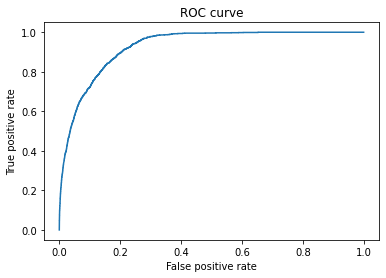

In [87]:
fpr, tpr, threshood = metrics.roc_curve(y_eval, y_scores, pos_label=1)
plt.plot(fpr, tpr, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

## Feature importance

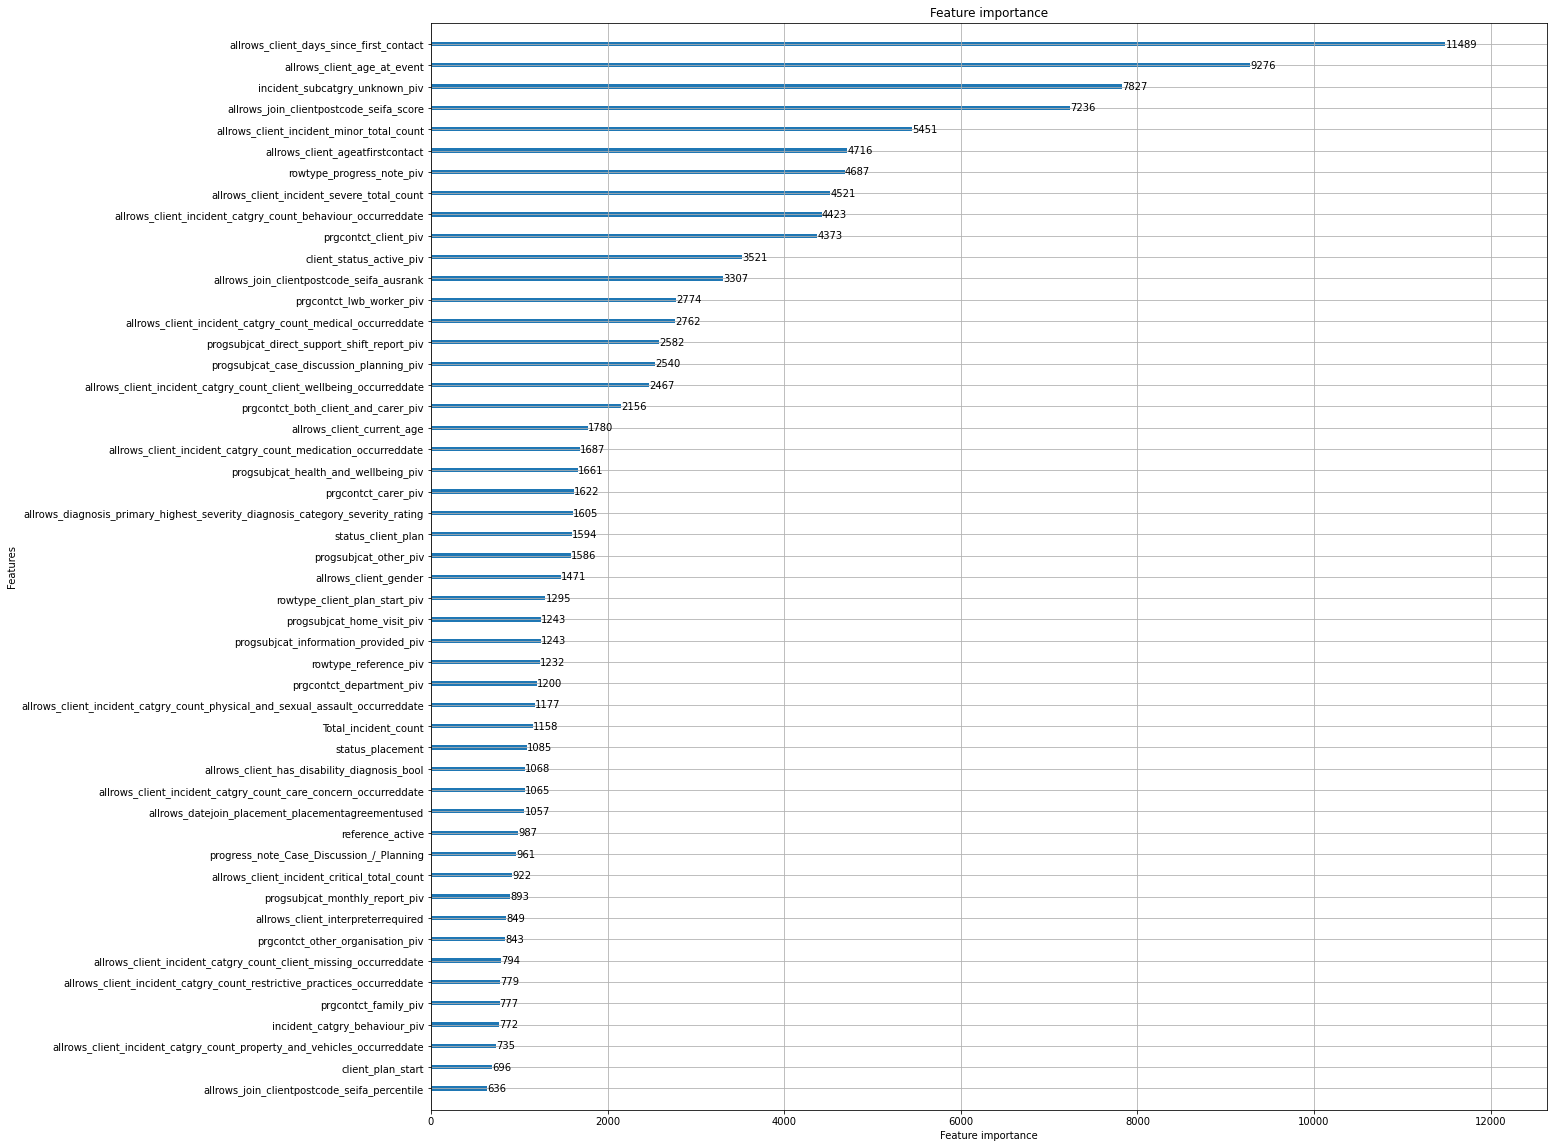

In [65]:
ax = lightgbm.plot_importance(model, figsize=(20,20),max_num_features=50)

<AxesSubplot:>

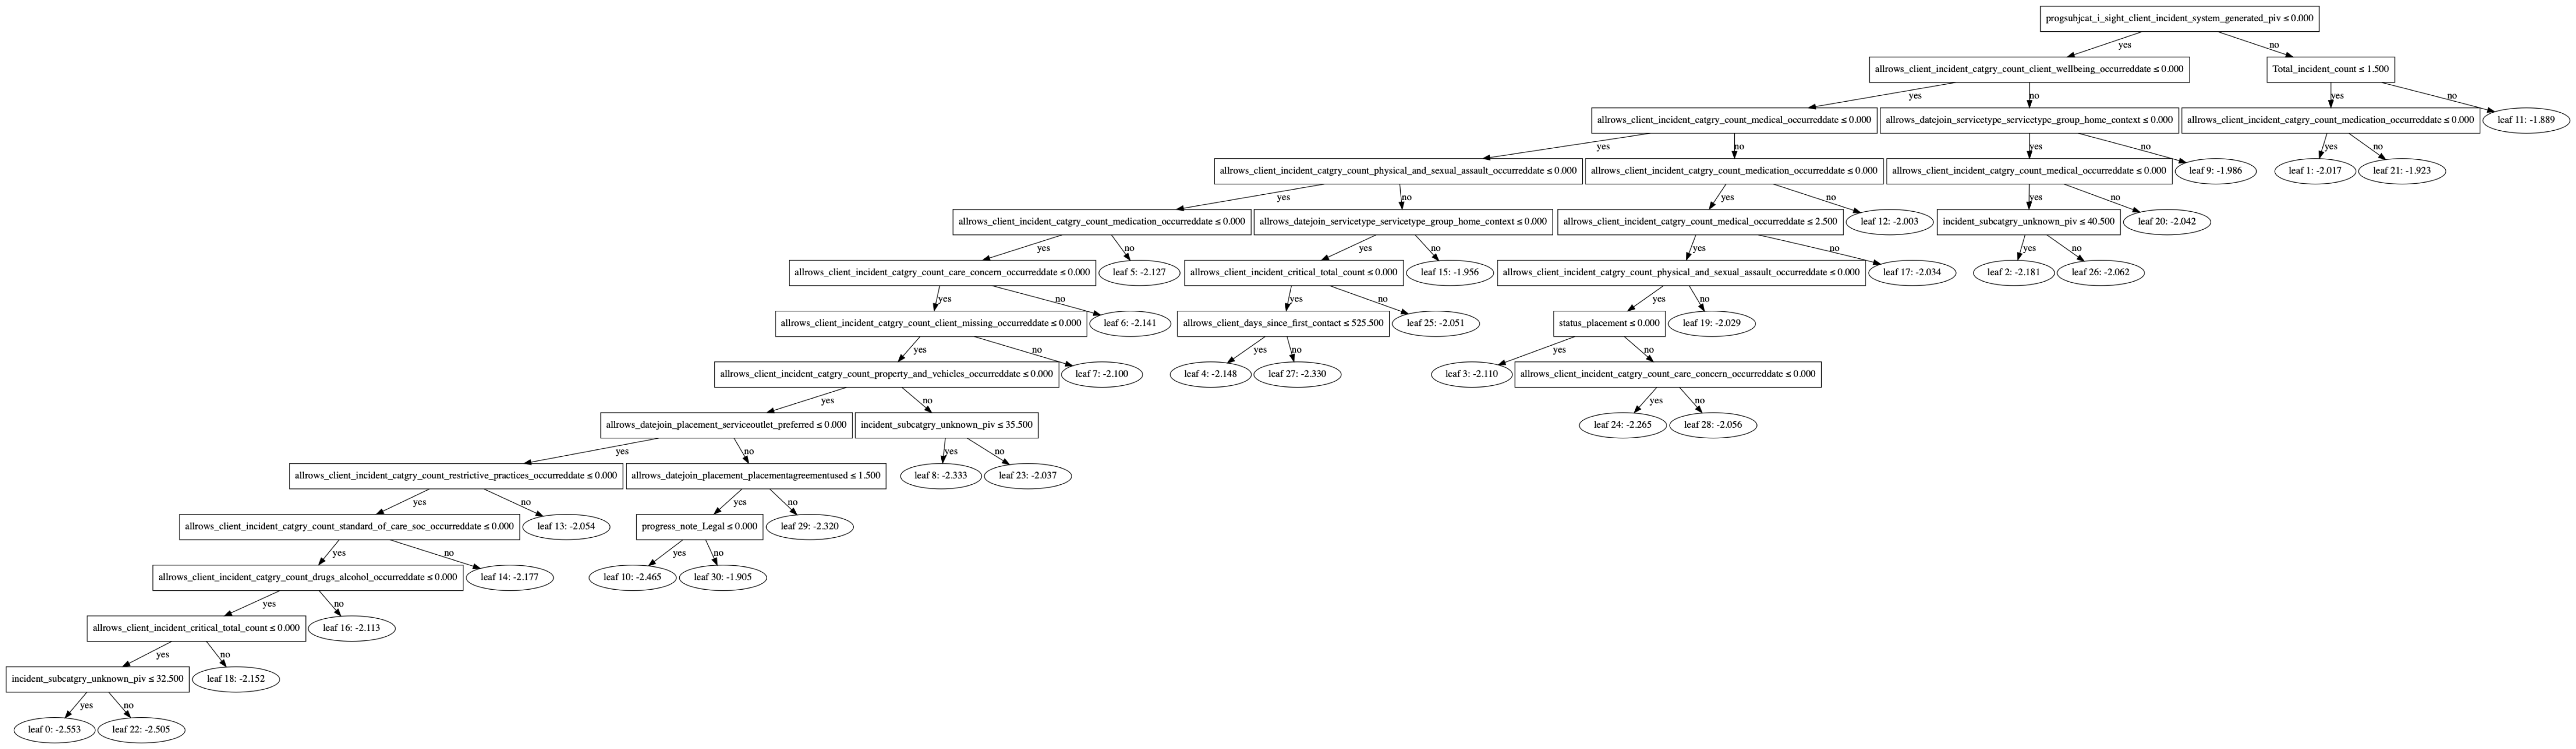

In [67]:
lightgbm.plot_tree(model,figsize=(100,100),orientation='vertical')

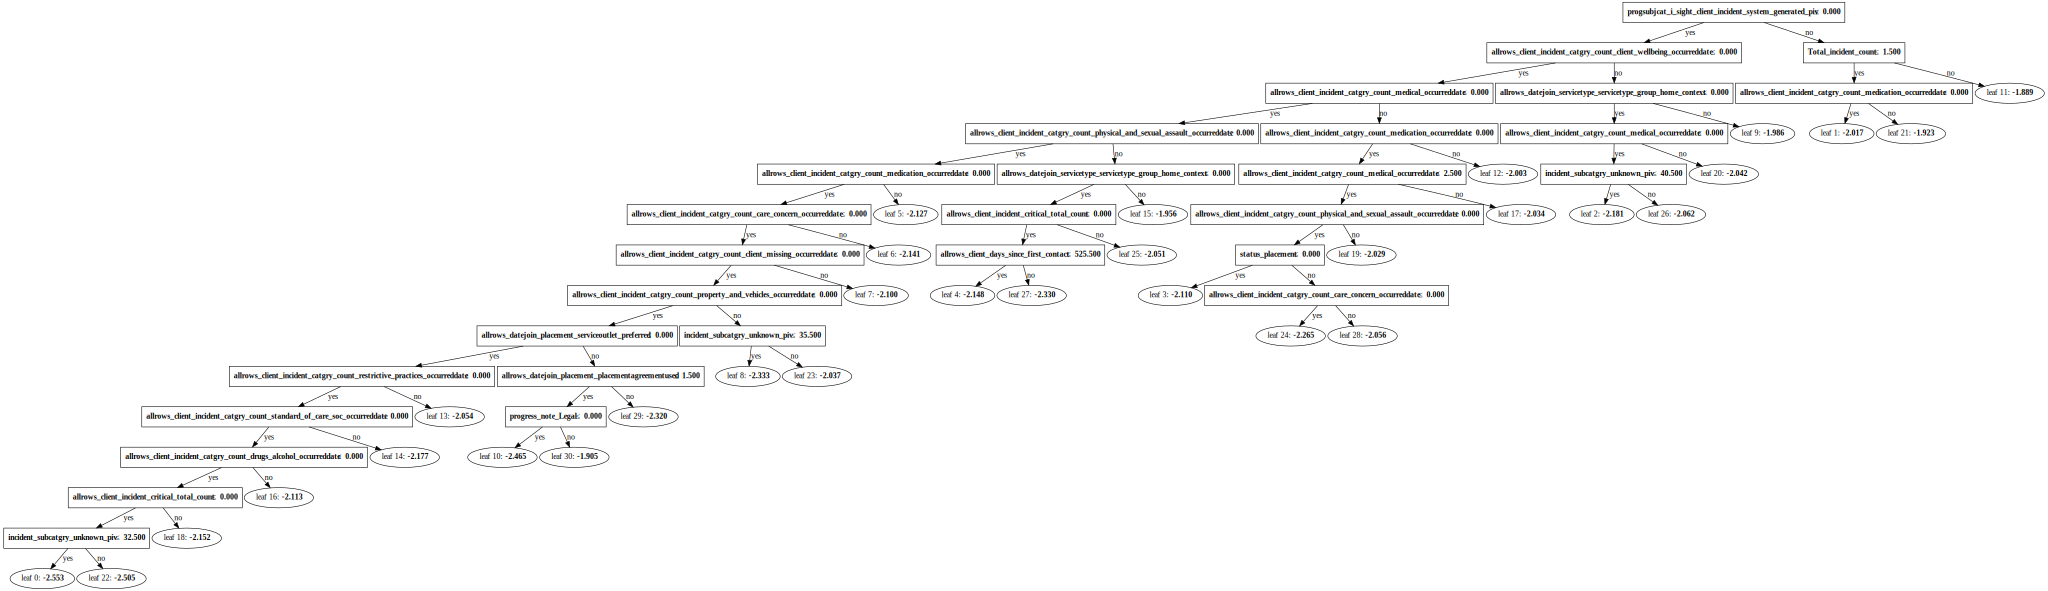

In [66]:
lightgbm.create_tree_digraph(model,orientation='vertical')

# Cross validation

In [50]:
model_cv = lightgbm.cv(parameters,
                       train_data,
                       num_boost_round=2000,return_cvbooster=True)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Curre

In [51]:
cv_result = model_cv["cvbooster"].predict(x_eval)

In [52]:
cv_result = np.array(cv_result)

#### Mean vote

In [53]:
y_hat = np.where(cv_result.mean(axis=0) < 0.5, 0, 1) 
f1_score(y_eval,y_hat)

0.5303237574099406